# Pong Agent!

<img src="Plan.jpg" width=80%>

**Required Libraries**

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

**Starting Pong Enviornment**

In [2]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


**Helper Functions + Tests**

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


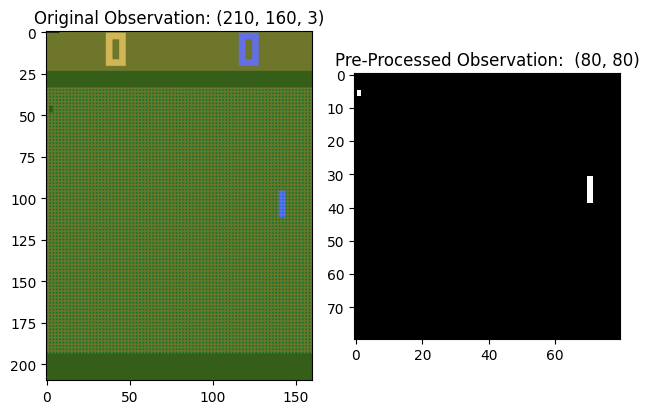

In [3]:
# Preprocessing Frames 
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return np.array(observation_frame.astype(float))

# Testing

env.seed(42)
env.reset()
observation, info = env.reset(seed=42)
processed_observation = frame_preprocessing(observation)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(observation)
plt.title(f"Original Observation: {observation.shape}")

plt.subplot(1,2,2)
plt.imshow(processed_observation, cmap='gray')
plt.title(f"Pre-Processed Observation:  {processed_observation.shape}")
plt.tight_layout()

**Neural Network (Policy) - without Pytorch**

Model Weights Initialization

In [4]:
model = {}

rng = np.random.default_rng(seed=12288743) # for reproducibility

D = 80 * 80 # Observation Dimensions
H = 200 # Number of Neruso in the Hidden Layers

# Weights from input to hidden layer
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D) 
# Weights from hidden layer to output
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H) 

Activation Functions:
* sigmoid(): Sigmoid activation function
* ReLU(): ReLU activation function

In [5]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def ReLU(x):
    x[x<0] = 0
    return x

def ReLU_derivative(x):
    return x>0

policy_forward(): Forward Pass

In [6]:
def policy_forward(model, x):
    
    # (Hx1) = (HxD) * (Dx1)
    hidden_layer_logits = model["W1"] @ x 

    # ReLU(logits)
    hidden_layer_activation = ReLU(hidden_layer_logits)

    # (1x1) = (Hx1).T * (Hx1)
    output_layer_logits = model["W2"] @ hidden_layer_activation

    # Scalar with probability of going up
    up_prob = sigmoid(output_layer_logits)

    return up_prob, hidden_layer_activation

policy_backward(): Backward Pass

In [7]:
def policy_backward(hidden_state, gradient_log_prob, obs, model):

    dW2 = np.dot(hidden_state.T,gradient_log_prob).ravel()

    dh = np.outer(gradient_log_prob, model["W2"])
    
    dh[hidden_state <= 0] = 0

    dW1 = np.dot(dh.T, obs)

    return {"W1": dW1, "W2": dW2} # Gradients

**History**

In [8]:
observations_history = [] # preprocessed Observations
hidden_logit_history = [] 
prob_log_history = [] 
rewards_history = [] # rewards

Buffers to store gradiants before updating the model weights

In [9]:
grad_buffer = {k: np.zeros_like(v) for k, v in model.items()}
rmsprop_cache = {k: np.zeros_like(v) for k, v in model.items()}

Discount Rate (Reward)

In [10]:
def discount_rewards(r, gamma=0.99):
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

Workflow

<img src="flow.png" width=80%>

**Hyperparameters**

In [25]:
decay_rate = 0.99
batch_size = 5
learning_rate = 1e-4
render = False
gamma = 0.99

Setup

In [26]:
prev_x = None
running_reward = None
reward_sum = 0
max_episodes = 100

# Makes the input x to the policy the difference between frames rather than the frame itself since most pixles in the frame are static most of the time
def update_input(prev_x, cur_x, D):
    if prev_x is not None:
        x = cur_x - prev_x
    else:
        x = np.zeros(D)
    return x

**Initialization** (ik i did it up, wanted to put it here again so it can be seen in context)

In [27]:
model = {}

rng = np.random.default_rng(seed=12288743) # for reproducibility

D = 80 * 80 # Observation Dimensions
H = 200 # Number of Neruso in the Hidden Layers

# Weights from input to hidden layer
model["W1"] = rng.standard_normal(size=(H, D)) / np.sqrt(D) 
# Weights from hidden layer to output
model["W2"] = rng.standard_normal(size=H) / np.sqrt(H) 

# History
observations_history = [] # preprocessed Observations
hidden_logits_history = [] 
prob_log_history = [] 
rewards_history = [] # rewards
actions_history = []

**Training Pong!**

In [28]:
observation, _ = env.reset()
episode_number = 0

while episode_number < max_episodes:

    if render:
        env.render()

    cur_x = frame_preprocessing(observation).ravel()
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x
    prob, hidden_logits = policy_forward(model,x)

    action = 0
    if rng.uniform() < prob:
        # Action 2 refers to moving up
        action = 2
    else:
        # Action 3 refers to moving down
        action = 3

    y = 1 if action == 2 else 0
    gradient_log_prob = y - prob

    observation, reward, done, *_ = env.step(action)

    observations_history.append(x)
    rewards_history.append(reward)
    actions_history.append(action)
    hidden_logits_history.append(hidden_logits)
    prob_log_history.append(gradient_log_prob)

    reward_sum += reward
    
    # Game ends when someone reach 21
    if done:

        episode_number += 1
        
        current_observations_history = np.vstack(observations_history)
        current_hidden_logits_history = np.vstack(hidden_logits_history)
        current_prob_log_history = np.vstack(prob_log_history)
        current_rewards_history = np.vstack(rewards_history)
        current_actions_history = np.vstack(actions_history)

        # Reseting histories
        observations_history = [] 
        hidden_logits_history = [] 
        prob_log_history = [] 
        rewards_history = []
        actions_history = []

        # Discount rewards by gamma and weighting it with prob_log
        discounted_rewards = discount_rewards(current_rewards_history, gamma)
        discounted_rewards = (discounted_rewards-np.mean(discounted_rewards))/(np.std(discounted_rewards))
        current_prob_log_history = current_prob_log_history * discounted_rewards
        weights_gradients = policy_backward(current_hidden_logits_history, current_prob_log_history, current_observations_history, model)

        for k in model:
            grad_buffer[k] += weights_gradients[k]

        if episode_number % batch_size == 0:
                    
            for k, v in model.items():

                g = grad_buffer[k]
                rmsprop_cache[k] = (
                    decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g ** 2
                )
                print("k: ", k)
                print("W Before: ", model[k])
                print("g: ", g)
                
                print("addition: ", learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5))

                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                print("W After: ", model["W1"])
                grad_buffer[k] = np.zeros_like(v)
        
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01

        print(f"Resetting the Pong environment. Episode total reward: {reward_sum} Running mean: {running_reward}")

        reward_sum = 0
        observation, _ = env.reset()
        prev_x = None


    if reward != 0: print( "Episode {}: Game finished. Reward: {}...".format(episode_number, reward)  + ("" if reward == -1 else " POSITIVE REWARD!"))

Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: -1.0...
Episode 0: Game finished. Reward: 1.0... POSITIVE REWARD!
Episode 0: Game finished. Reward: -1.0...
Resetting the Pong environment. Episode total reward: -20.0 Running mean: -20.0
Episode 1: Game finish

KeyboardInterrupt: 

/var/folders/y_/g46v5wcs2mlg96p8tytg8l7m0000gn/T/ipykernel_40464/1313711264.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


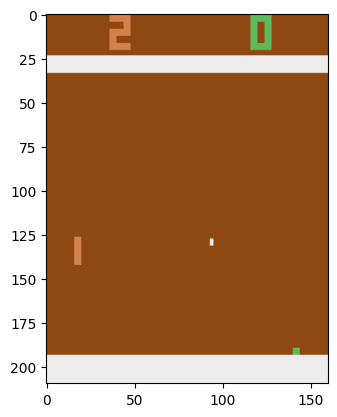

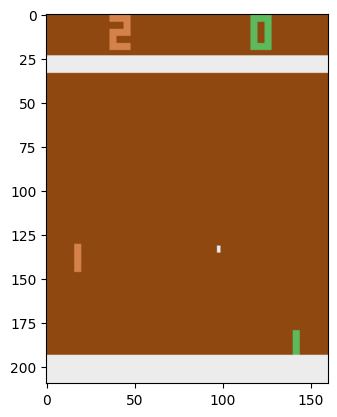

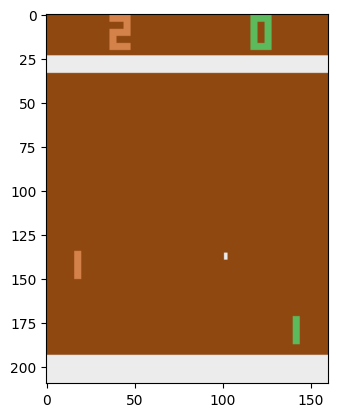

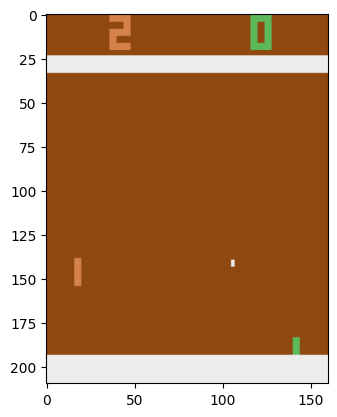

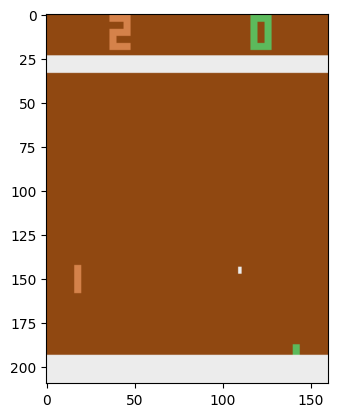

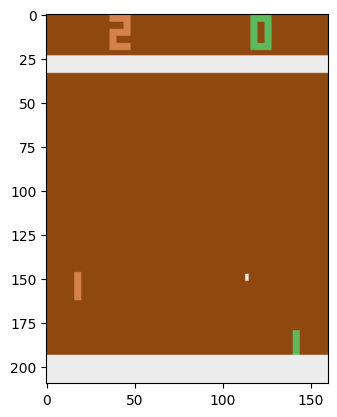

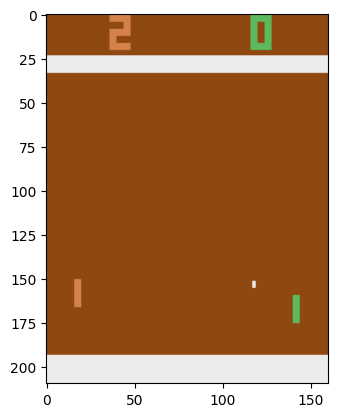

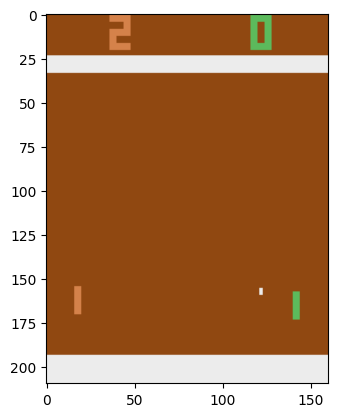

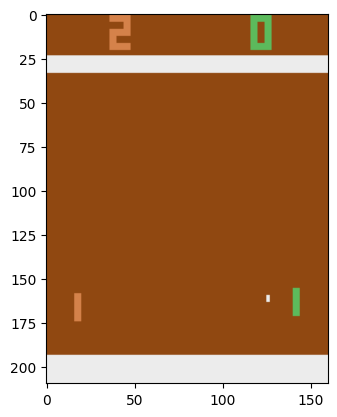

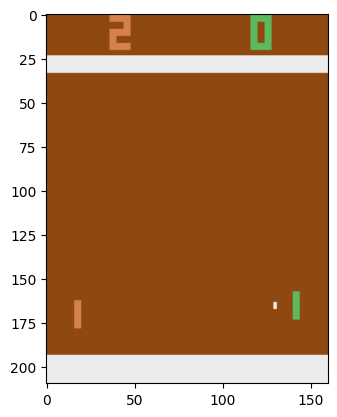

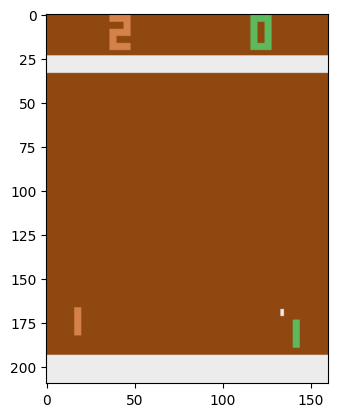

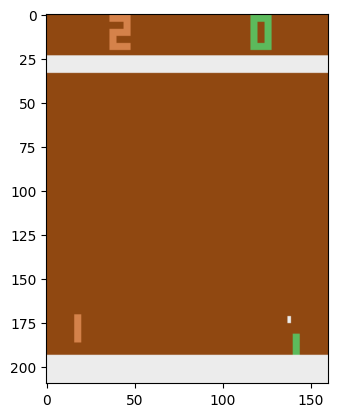

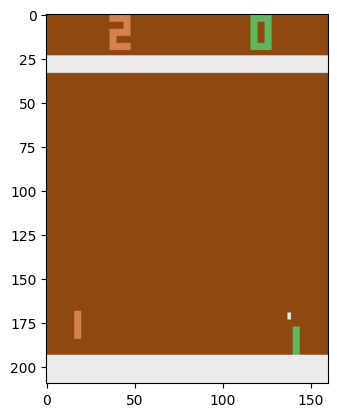

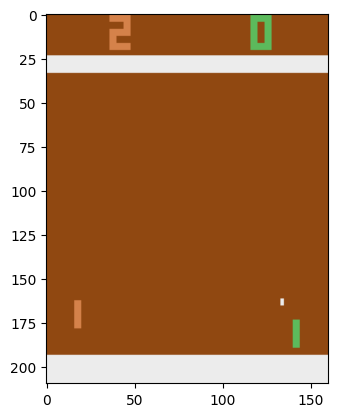

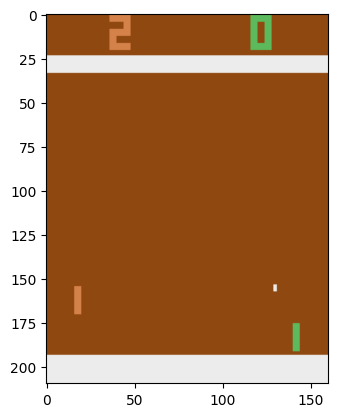

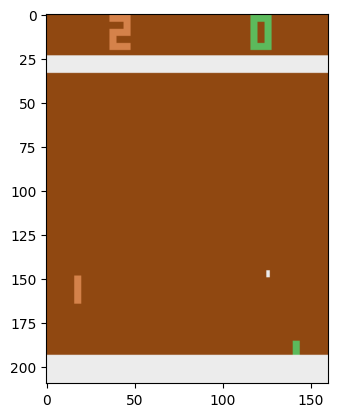

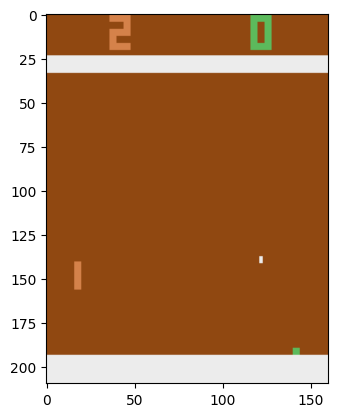

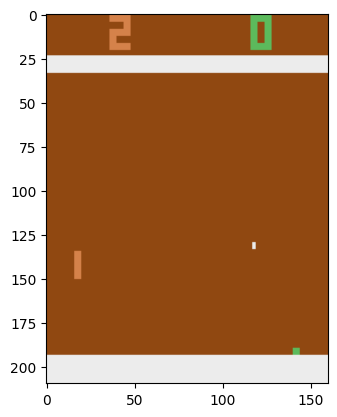

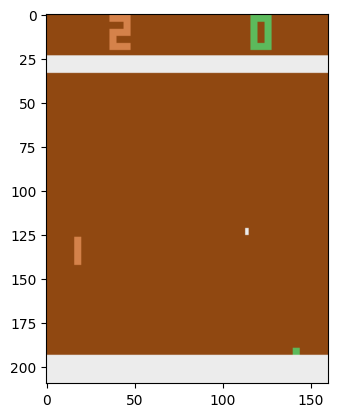

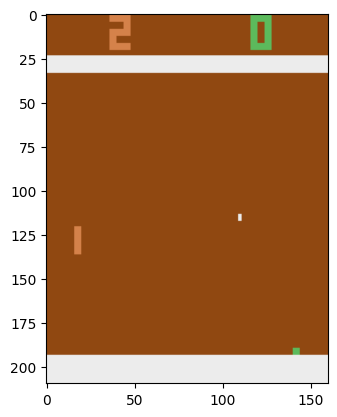

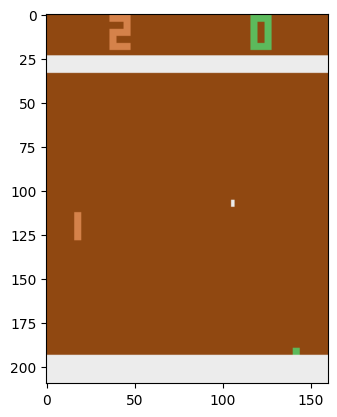

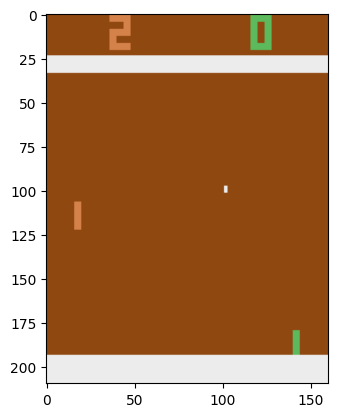

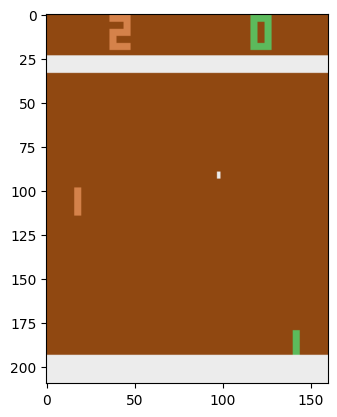

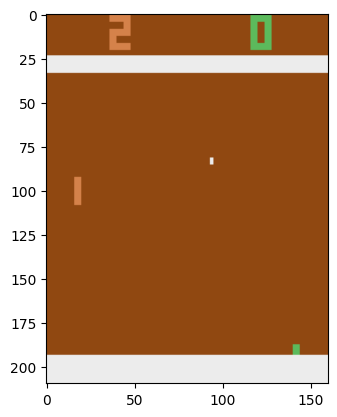

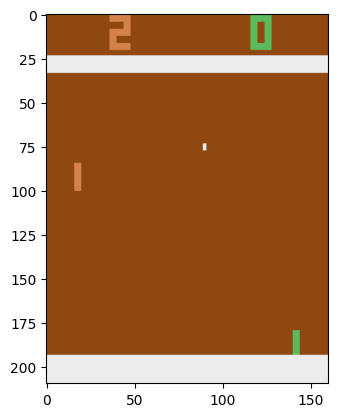

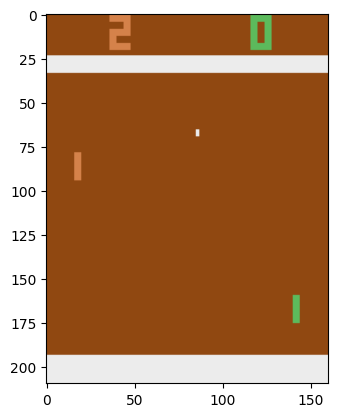

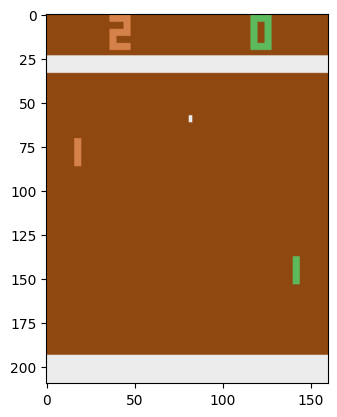

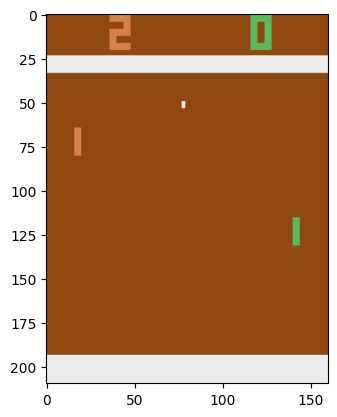

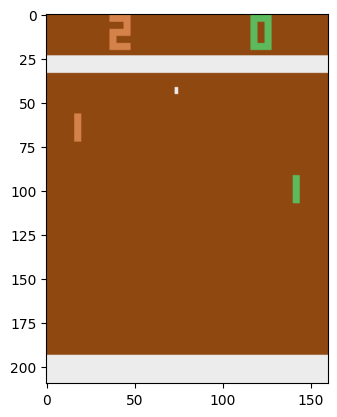

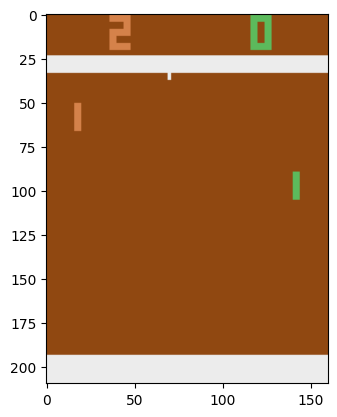

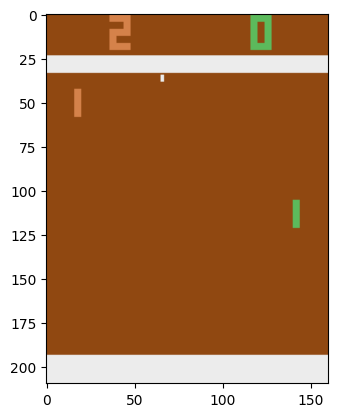

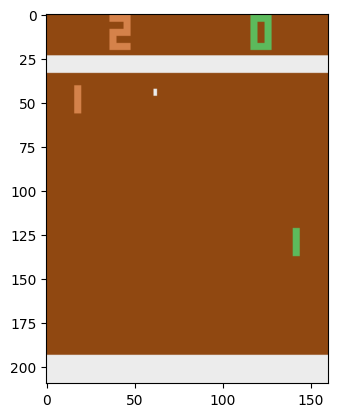

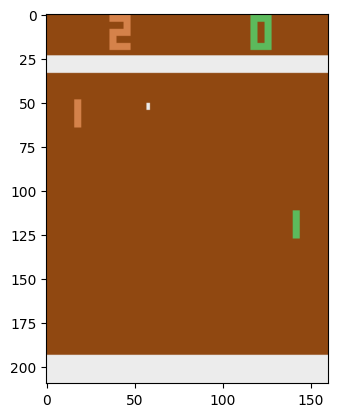

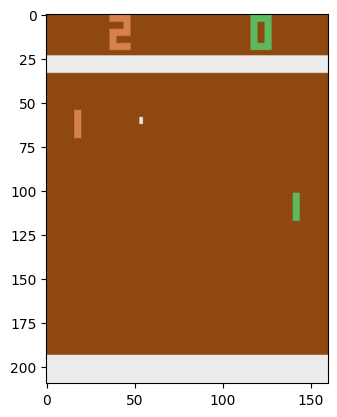

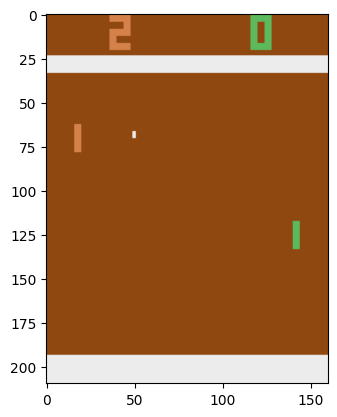

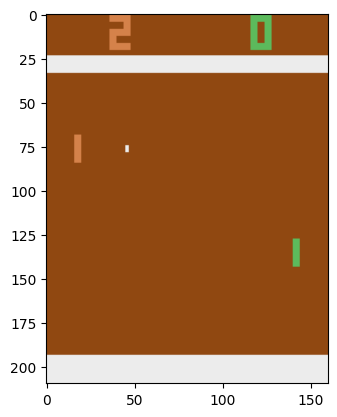

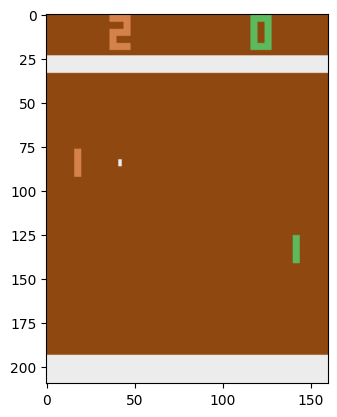

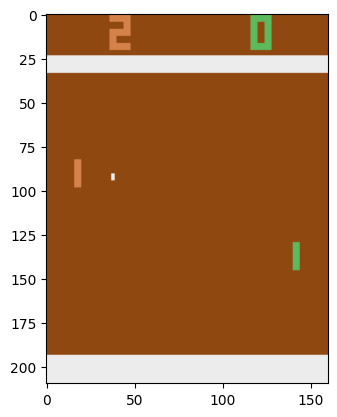

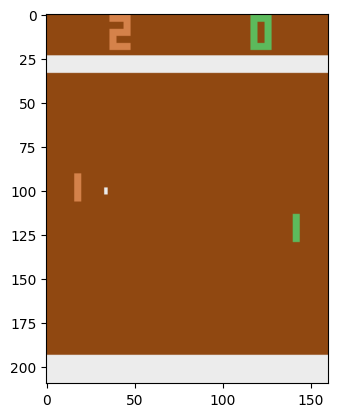

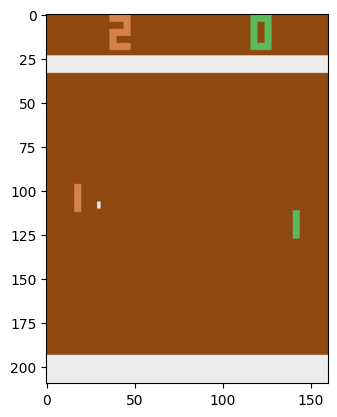

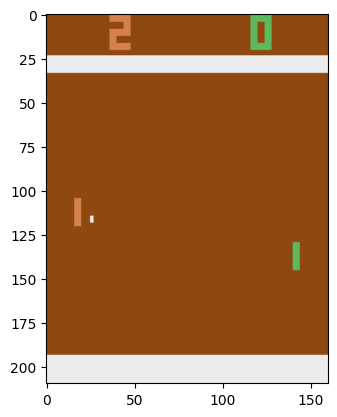

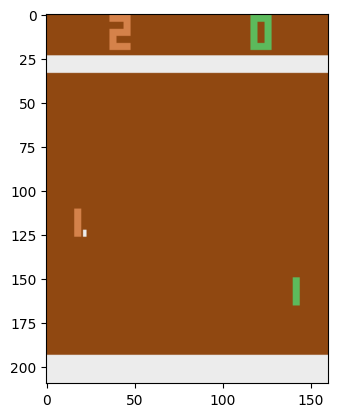

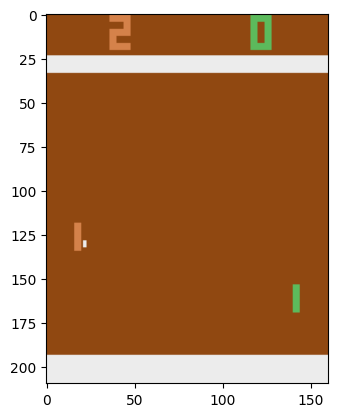

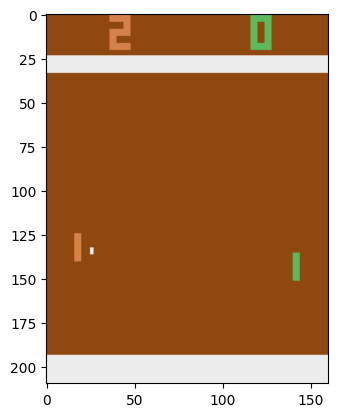

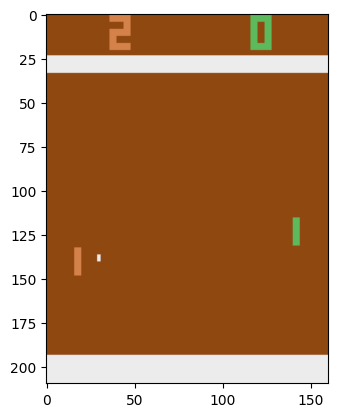

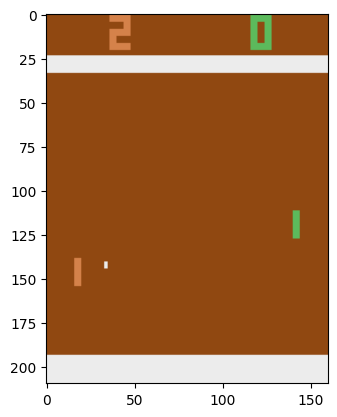

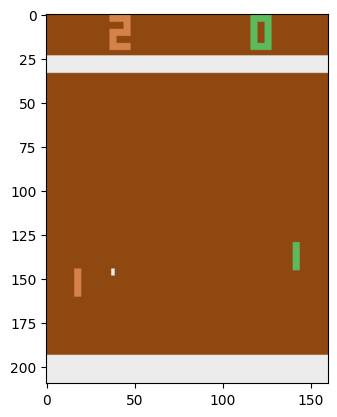

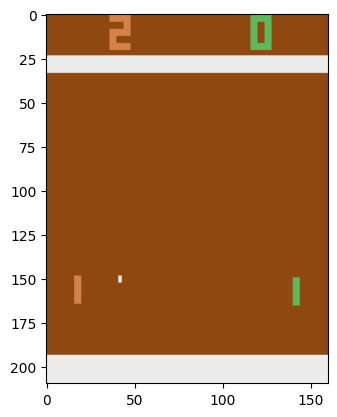

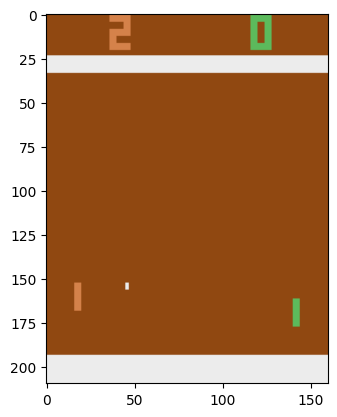

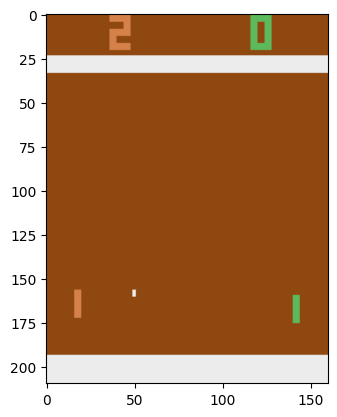

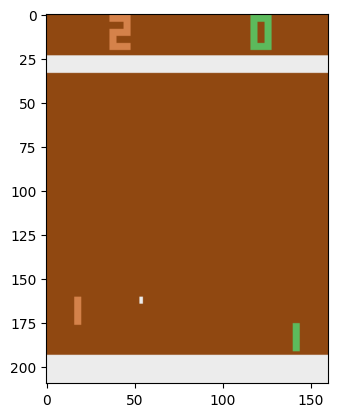

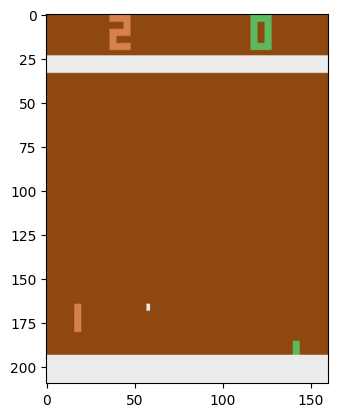

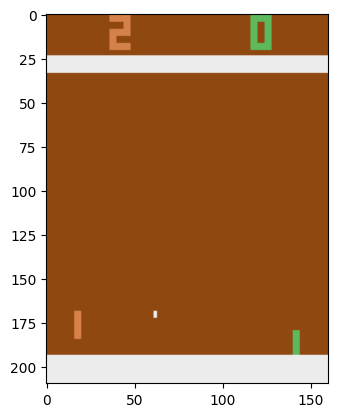

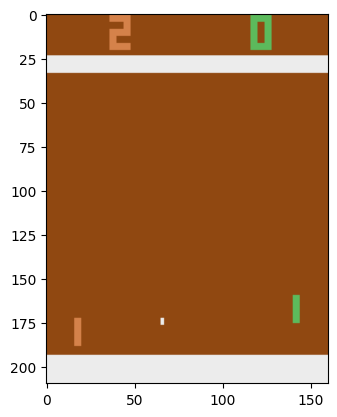

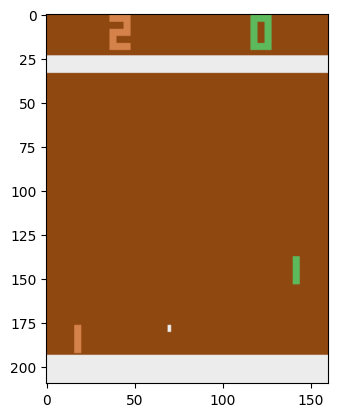

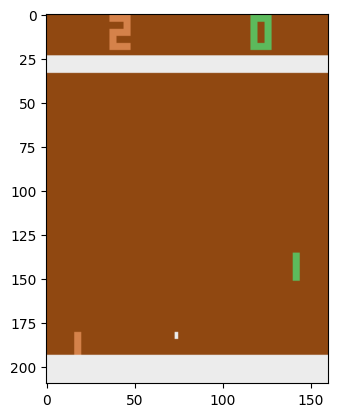

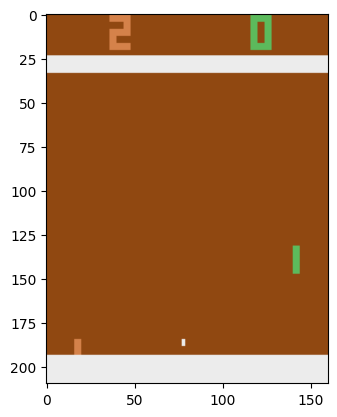

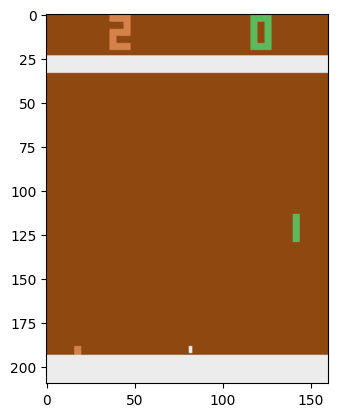

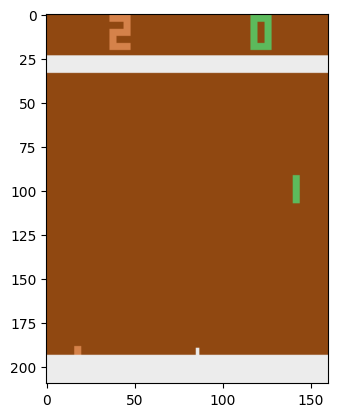

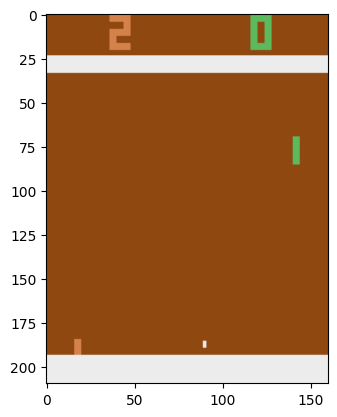

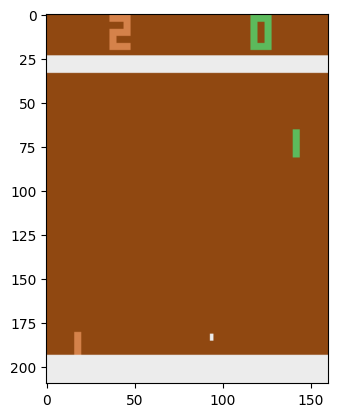

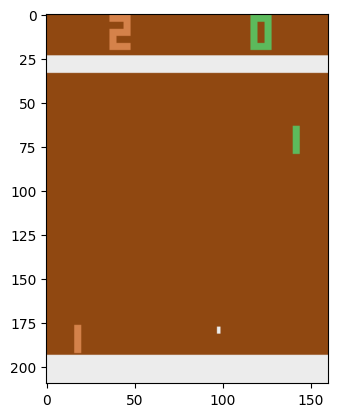

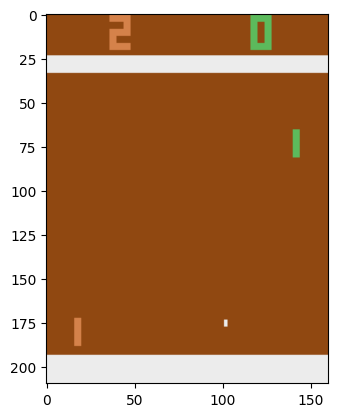

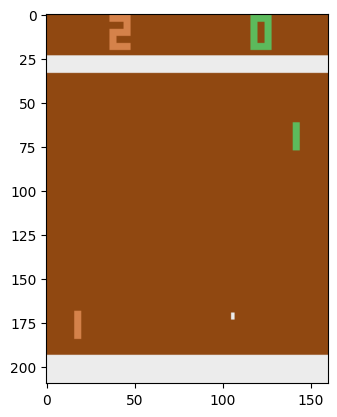

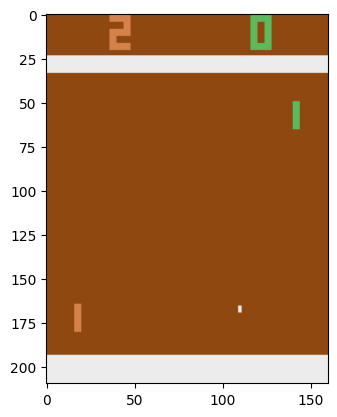

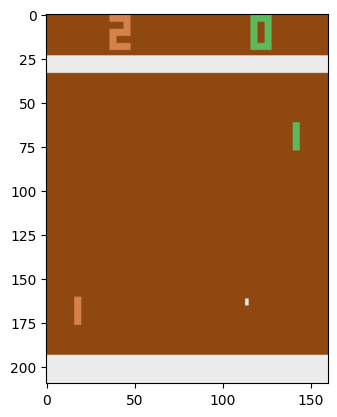

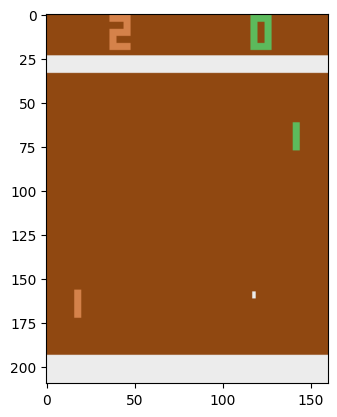

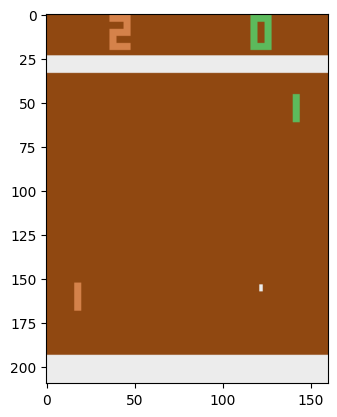

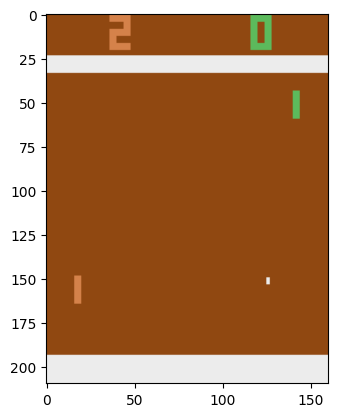

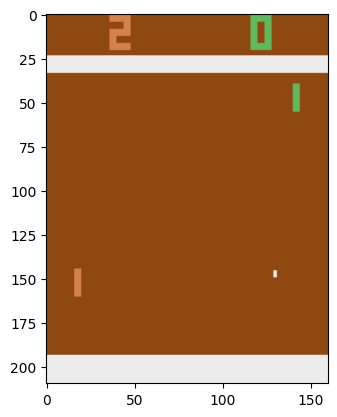

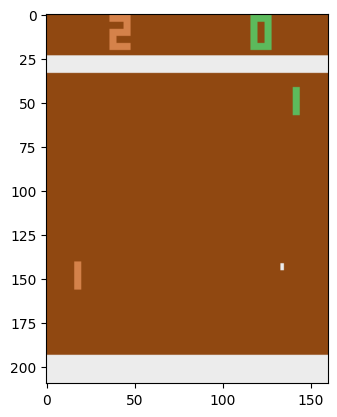

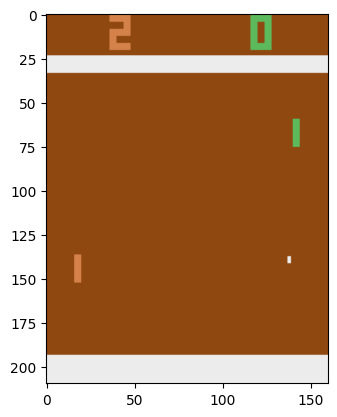

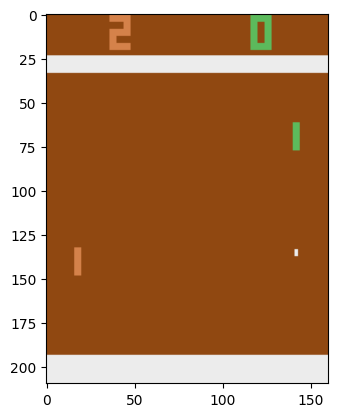

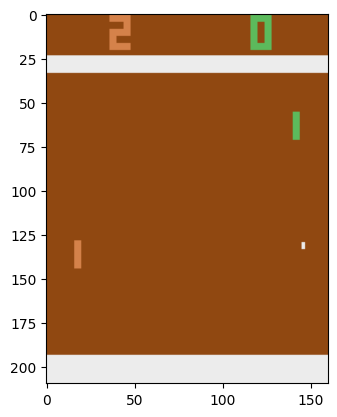

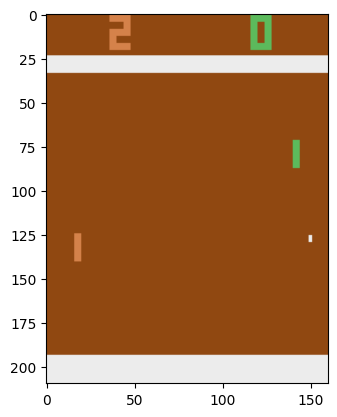

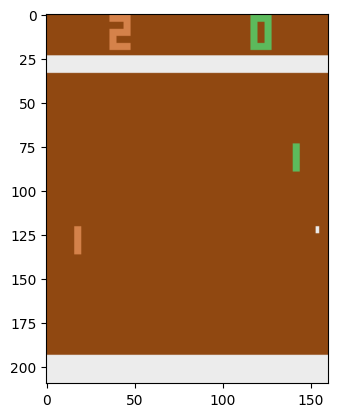

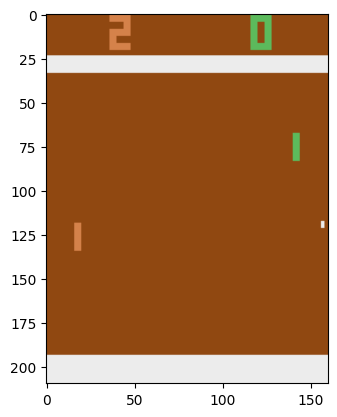

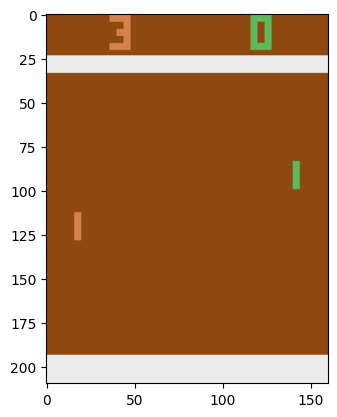

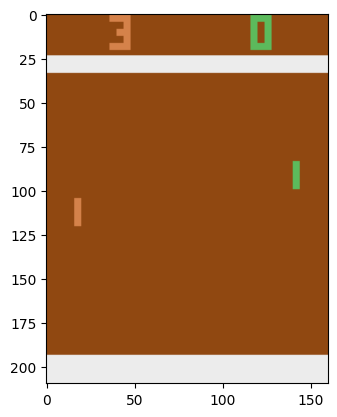

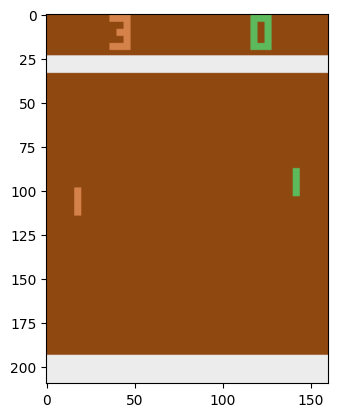

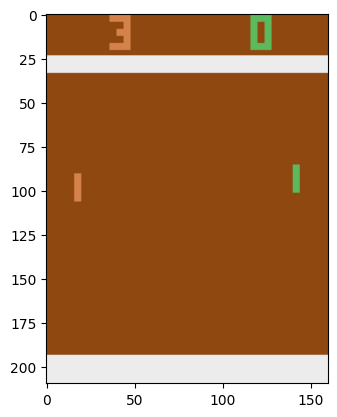

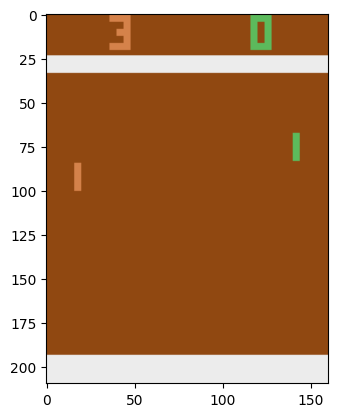

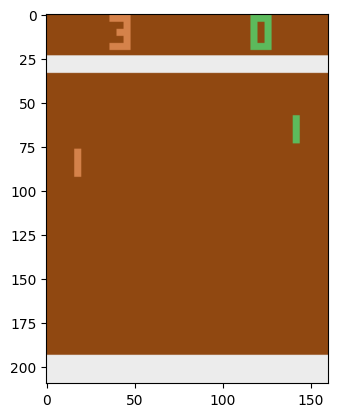

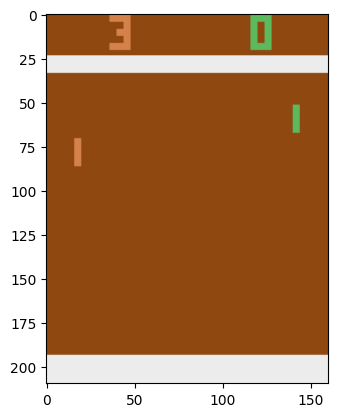

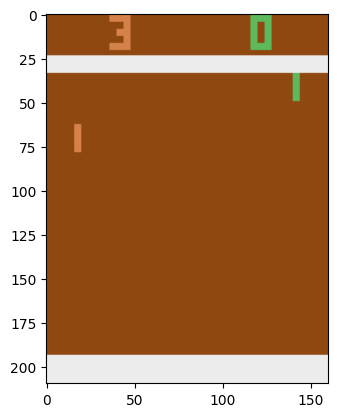

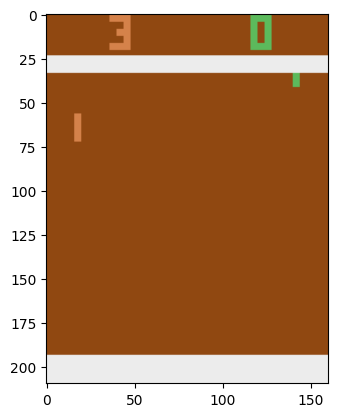

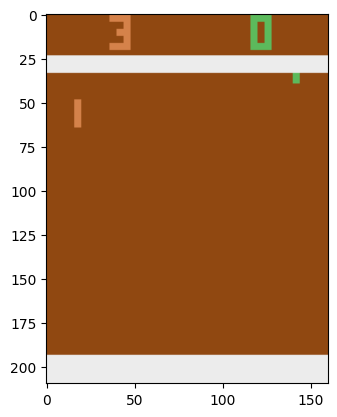

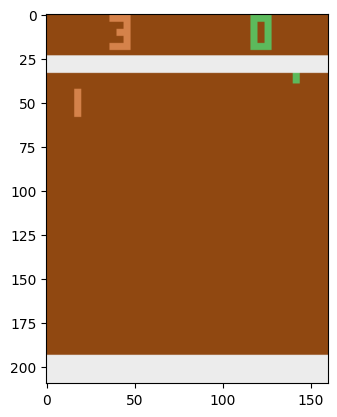

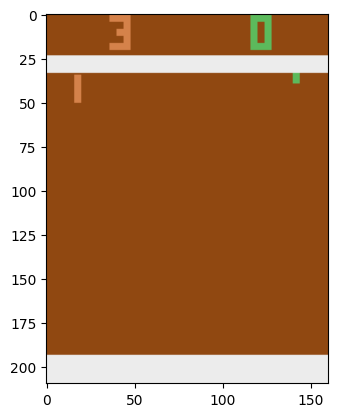

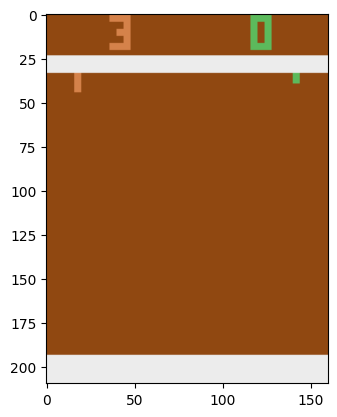

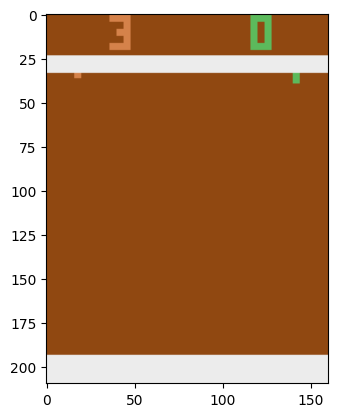

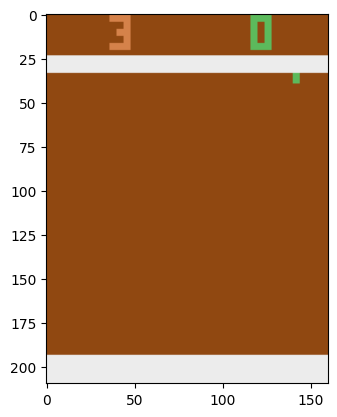

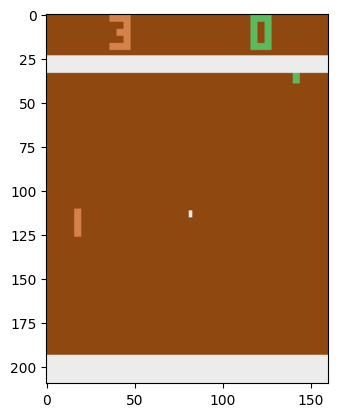

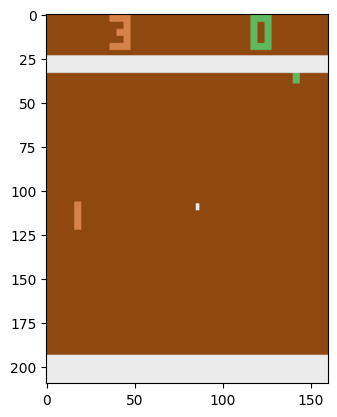

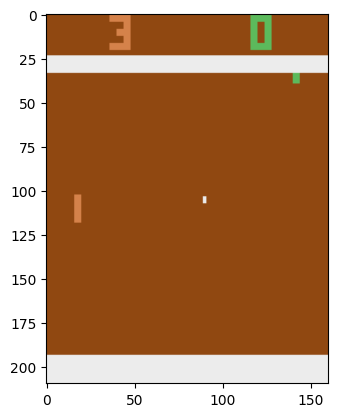

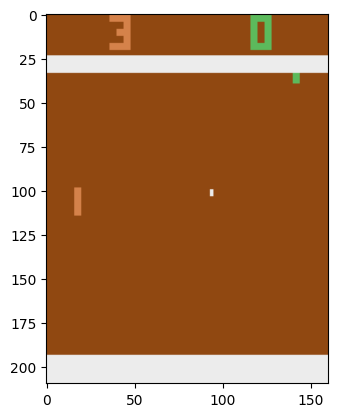

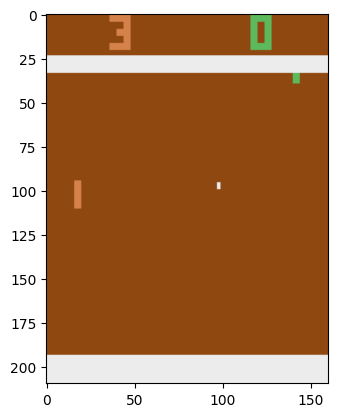

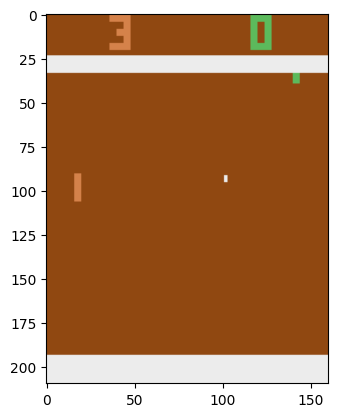

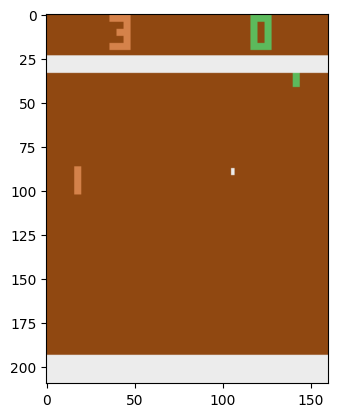

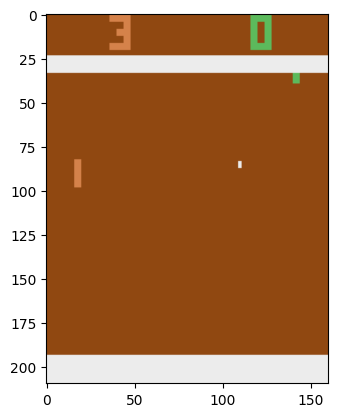

In [30]:
for i in range(100):

    cur_x = frame_preprocessing(observation).ravel()
    x = update_input(prev_x, cur_x, D)
    prev_x = cur_x
    prob, hidden_logits = policy_forward(model,x)

    action = 0
    if rng.uniform() < prob:
        # Action 2 refers to moving up
        action = 2
    else:
        # Action 3 refers to moving down
        action = 3

    y = 1 if action == 2 else 0
    gradient_log_prob = y - prob

    observation, reward, done, *_ = env.step(action)
    plt.figure()
    plt.imshow(observation)